# The ROC Curve

### Notebook Contents
- Quick theoretical overview
- Practical example on the Breast Cancer Dataset

## Quick overview

In this notebook, we are constructing a ROC curve from scratch, using its own definition. The ROC curve is built when plotting the TPR (True Positive Rate) versus the FPR (False Positive Rate) of a given validation set. These two metrics can be computed as:

- $TPR = \frac{TP}{TP + FN}$
- $FPR = \frac{FP}{FP + TN}$

where $TP$, $FP$, $TN$ and $FN$ are, respectively, the count of True Positives, False Positives, True Negatives and False Negatives obtained from the Confusion Matrix of a given validation set. For a binary classification problem (which is our case in the notebook), the confusion matrix resembles the following:

|  | Prediction 1 | Prediction 0 |
| --- | --- | --- |
| Label 1 | TP | FN|
| Label 0 | FP| TN |

That is, when a given record is labeled as $1$ and (correctly) predicted as $1$, it counts as a True Positive ($TP$) prediction. The next correct predicted records are the True Negatives ($TN$), that occur when a record is labeled as $0$ and correctly predicted as $0$. However, the classifier also makes mistakes and wrongly predicts the class of a record. When the record is labeled as $0$, and the classifier predicts it as a positive (label $1$), the result is a False Positive ($FP$). When the opposite occurs, the result is a False Negative ($FN$). A theoretical perfect classifier would have numbers different from zero only on the diagonals of the confusion matrix, that is, would never predict any label wrongly.
However, the output a Machine Learning model for a classification problem is usually a probability of the prediction. In most cases, the ML engineers or data scientists are responsible to assigning a given threshold between $0$ and $1$ that converts the probability into a prediction. Low threshold values (for instance 0.1) would classify records with low probabilities into positive classes and increase the $FP$ while decreasing the $FN$ of the confusion matrix. This would lead to a larger chance to correctly predict a few examples with low probabilities at the cost of adding positive predictions on negative labels. The opposite is also true, a larger threshold would not correctly predict positive cases but would correctly predict more negative labels. The choice of the final threshold largely relies on the problem. The ROC curve, however, is constructed by varying the threshold and computing the metrics given that the confusion matrix is different for each set of predictions. That said, let's show how it works with an example:

## Practical Example

Here we load all the needed packages for our example. Note that there are some functions in the `utils` directory. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from utils import compute_confusion_matrix, compute_tpr_fpr, display_side_by_side



The Breast Cancer Dataset contains 569 records and 30 features. Before going into the ROC curve, let's take a good look at the confusion matrix of a stratified validation set of 20% of the data. We'll create three confusion matrices for the thresholds of 0.1, 0.5 and 0.9.

In [2]:
# Load dataset
X, y = load_breast_cancer(return_X_y=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, y.reshape(-1))
clf.fit(X_train, y_train)  # Fit
y_pred_proba = clf.predict_proba(X_valid)[:, 1]

low_thresh_conf_matrix = compute_confusion_matrix(y_valid, y_pred_proba, threshold=0.1)
med_thresh_conf_matrix = compute_confusion_matrix(y_valid, y_pred_proba, threshold=0.5)
high_thresh_conf_matrix = compute_confusion_matrix(y_valid, y_pred_proba, threshold=0.9)

display_side_by_side(low_thresh_conf_matrix, 
                     med_thresh_conf_matrix, 
                     high_thresh_conf_matrix, 
                     titles=["Low Threshold", "Medium Threshold", "High Threshold"])

Low Threshold 
 
 
 
 
 Prediction 
 
 
 
 
 1 
 0 
 
 
 
 
 True 
 1 
 35 
 7 
 
 
 0 
 0 
 72 
 
 
 Medium Threshold 
 
 
 
 
 Prediction 
 
 
 
 
 1 
 0 
 
 
 
 
 True 
 1 
 39 
 3 
 
 
 0 
 2 
 70 
 
 
 High Threshold 
 
 
 
 
 Prediction 
 
 
 
 
 1 
 0 
 
 
 
 
 True 
 1 
 42 
 0 
 
 
 0 
 13 
 59

Note that:

* for the `Low Threshold` case, we had a small number of $FP$ and a large number of $FN$
* for the `Medium Threshold` case, we had a similar number of both $FP$ and $FN$
* for the `High Threshold`case, we had a small number of $FN$ and a large number of $FP$

Now we proceed to compute the $TPR$ and $FPR$ metrics required for the ROC curve:

In [3]:
# Compute TPR and FPR for the three tested cases
confusion_matrices = {'Low' : low_thresh_conf_matrix,
                      'Medium' : med_thresh_conf_matrix,
                      'High' : high_thresh_conf_matrix}

df_metrics = compute_tpr_fpr(confusion_matrices)
df_metrics.head()

,Threshold,TPR,FPR
0,Low,0.833333,0.0
1,Medium,0.928571,0.027778
2,High,1.0,0.180556


Let's plot the three points for the three tested cases. They are a good indicator that our ROC curve looks good!

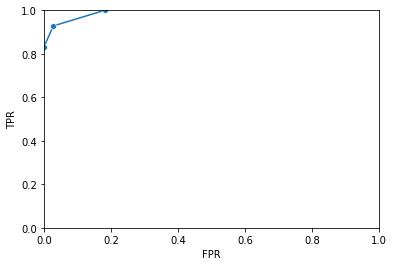

In [4]:
# Plot the three points
ax = sns.lineplot(data=df_metrics,
             x='FPR',
             y='TPR',
             marker='o')
ax.set(ylim=(0,1), xlim=(0,1))
plt.show()
             

Let's compute a more rich ROC curve using 22 equally spaced points for various thresholds (from 0.00 to 1.00 using a step of 0.05).

In [5]:
# Compute the ROC curve for 22 points (threshold ranging from 0.00 to 1.00 using a 0.05 step)
confusion_matrices = {}
for thresh in np.arange(0.00,1.05,0.05):
    df_confusion = compute_confusion_matrix(y_valid, y_pred_proba, threshold=thresh)
    confusion_matrices[str(thresh)] = df_confusion

df_metrics = compute_tpr_fpr(confusion_matrices)
df_metrics.head()

,Threshold,TPR,FPR
0,0.0,0.0,0.0
1,0.05,0.833333,0.0
2,0.1,0.833333,0.0
3,0.15000000000000002,0.857143,0.0
4,0.2,0.857143,0.0


Let's plot our new points and compare with the ROC curve created by `sklearn` 

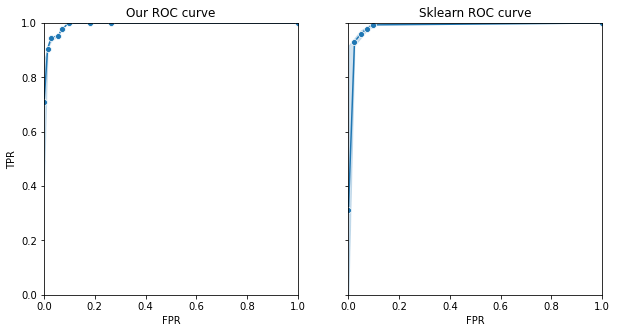

In [6]:
# Plot all points
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
sns.lineplot(ax=axes[0],
                  data=df_metrics,
                  x='FPR',
                  y='TPR',
                  marker='o')
axes[0].set(ylim=(0,1), xlim=(0,1))
axes[0].set_title('Our ROC curve')

fpr_sk, tpr_sk, thresh_sk = roc_curve(y_valid, y_pred_proba)
df_metrics_sk = pd.DataFrame(zip(fpr_sk, tpr_sk), columns=['FPR', 'TPR'], index=thresh_sk).sort_index()
sns.lineplot(ax=axes[1],
                  data=df_metrics_sk,
                  x='FPR',
                  y='TPR',
                  marker='o')
axes[1].set(ylim=(0,1), xlim=(0,1))
axes[1].set_title('Sklearn ROC curve')
plt.show()

Although they look similar (and indicating that our classifier is working well!), let's use the same thresholds used by `sklearn` to create a more similar version of our plot!

In [7]:
# Compute the ROC curve for the same threshold used in sklearn
confusion_matrices = {}
for thresh in thresh_sk:
    df_confusion = compute_confusion_matrix(y_valid, y_pred_proba, threshold=thresh)
    confusion_matrices[str(thresh)] = df_confusion

df_metrics = compute_tpr_fpr(confusion_matrices)
df_metrics.head()

,Threshold,TPR,FPR
0,1.9999248026821386,1.0,1.0
1,0.9999248026821387,1.0,0.986111
2,0.8421241986443315,1.0,0.083333
3,0.8303171610153073,0.97619,0.083333
4,0.7956795579996301,0.97619,0.055556


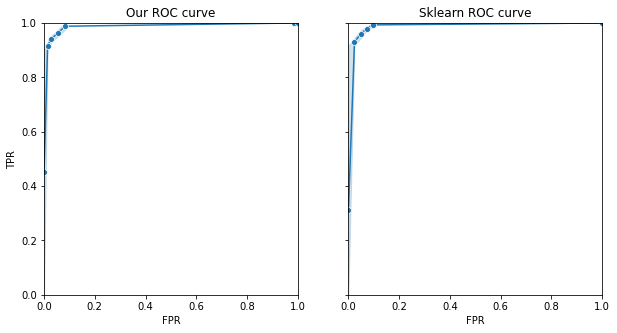

In [8]:
# Plot all points
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
sns.lineplot(ax=axes[0],
                  data=df_metrics,
                  x='FPR',
                  y='TPR',
                  marker='o')
axes[0].set(ylim=(0,1), xlim=(0,1))
axes[0].set_title('Our ROC curve')

sns.lineplot(ax=axes[1],
                  data=df_metrics_sk,
                  x='FPR',
                  y='TPR',
                  marker='o')
axes[1].set(ylim=(0,1), xlim=(0,1))
axes[1].set_title('Sklearn ROC curve')
plt.show()

That's it! Now you know how to build your own ROC curves for binary classification problems!

For any suggestion, correction or improvement, e-mail me at gabrielfregugliabarros@gmail.com